### Getting Started with MLFlow
Let's find out how to:
- Prepare the local env
- Install mlflow client and configure its backend
- Add MLFlow to the existing notebook, log some parameters and show it in MLFlow UI

In [35]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

We run mlflow using sqlite backend, thus the uri is: `sqlite:///mlflow.db` 

In [36]:
import mlflow

mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('experiment_1')

2022/06/22 04:24:43 INFO mlflow.tracking.fluent: Experiment with name 'experiment_1' does not exist. Creating a new experiment.


<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='experiment_1', tags={}>

In [10]:
data = pd.read_parquet('../data/green_tripdata_2021-01.parquet')
data

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,0.50,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,0.50,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,0.50,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,0.50,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,0.00,-0.5,0.00,0.00,None,-0.3,-52.80,3.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,2.75,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,0.00,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,2.75,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,2.75,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN


If problems running `pd.read_parquet` use: `!pip install pyarrow`

In [11]:
print('Features:') 
data.columns.to_list()

Features:


['VendorID',
 'lpep_pickup_datetime',
 'lpep_dropoff_datetime',
 'store_and_fwd_flag',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'passenger_count',
 'trip_distance',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'ehail_fee',
 'improvement_surcharge',
 'total_amount',
 'payment_type',
 'trip_type',
 'congestion_surcharge']

Interesting Columns:
- PickUpLocationId
- DropOffLocationId
- Trip Distance

In [12]:
# 1. Create Target Feature (Duration)
data['duration'] = data['lpep_dropoff_datetime'] - data['lpep_pickup_datetime']
data['duration'] = data['duration'].apply(lambda x: x.total_seconds() / 60)
data['duration']

0         3.933333
1         8.750000
2         5.966667
3         7.083333
4         0.066667
           ...    
76513    38.000000
76514    38.000000
76515    11.000000
76516    27.000000
76517    10.000000
Name: duration, Length: 76518, dtype: float64

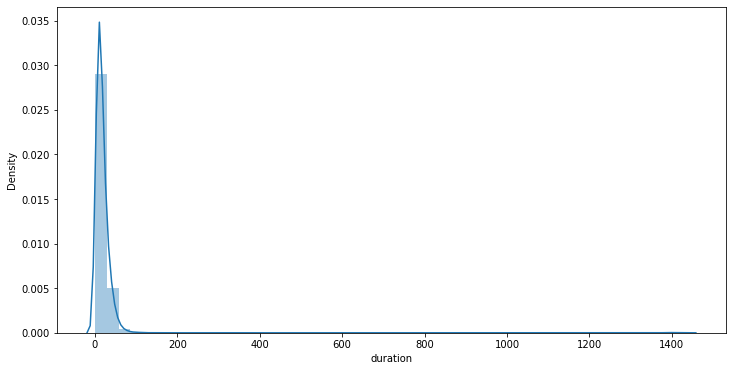

In [13]:
# 2. Let's have a look at target distribution
plt.figure(figsize=(12,6))
sns.distplot(data['duration']);

In [14]:
# 3. We see extreamly big and shrt duration trips
data['duration'].describe()

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: duration, dtype: float64

In [15]:
data['duration'].describe(percentiles=[0.95, 0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [16]:
# 4. let's filter the data and leave trips that more than 1 min and less than 60
data = data[(data['duration'] >= 1) & (data['duration'] <= 60)]
data

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.50,...,0.5,0.96,0.00,None,0.3,5.76,1.0,1.0,0.00,2.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000


In [17]:
# 5. let's pick some base line features 
cat_columns = ['PULocationID', 'DOLocationID']
num_columns = ['trip_distance']

In [18]:
cat_dummies = pd.get_dummies(data=data[cat_columns], columns=cat_columns, prefix_sep='_is_')
df = pd.concat([data[num_columns], cat_dummies], axis='columns')
df.head()

,trip_distance,PULocationID_is_3,PULocationID_is_4,PULocationID_is_7,PULocationID_is_8,PULocationID_is_9,PULocationID_is_10,PULocationID_is_11,PULocationID_is_12,PULocationID_is_13,...,DOLocationID_is_256,DOLocationID_is_257,DOLocationID_is_258,DOLocationID_is_259,DOLocationID_is_260,DOLocationID_is_261,DOLocationID_is_262,DOLocationID_is_263,DOLocationID_is_264,DOLocationID_is_265
0,1.01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.53,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.99,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0.45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# 6. Create X_train and y_train
X_train = df.copy()
y_train = data['duration']

print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)

X_train Shape:  (73908, 507)
y_train Shape:  (73908,)


In [20]:
# 7. Train a model (simle Lin_reg)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [21]:
# 8. Let's make a prediction on the same data
y_pred = model.predict(X_train)

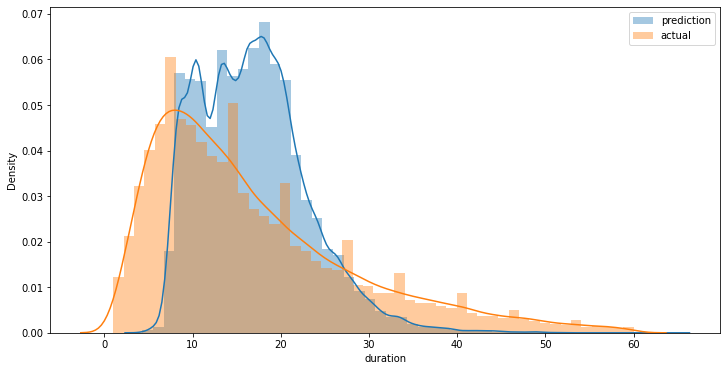

In [22]:
# 9. Let's have a look at distriburion (y_pred, y_train)
plt.figure(figsize=(12,6))
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')
plt.legend();

Comparision gives a sense that the score will be bad. We badly predict the target distribution

In [23]:
print('RMSE: ', mean_squared_error(y_train, y_pred, squared=False))

RMSE:  9.775258694561622


On average the model is wrong by 9 minutes (it's bad and this is the quality on Train Data)

Let it be the baseline

### Baseline Improving 

In [24]:
# 1. Create a func for features obtaining 
def prepare_df(filename):
    data = pd.read_parquet(filename)
    
    # Target Creation
    data['duration'] = data['lpep_dropoff_datetime'] - data['lpep_pickup_datetime']
    data['duration'] = data['duration'].apply(lambda x: x.total_seconds() / 60)
    
    # Filtering
    data = data[(data['duration'] >= 1) & (data['duration'] <= 60)]
    return data

def transform_df(df, cat_columns, num_columns):
    cat_dummies = pd.get_dummies(data=df[cat_columns], columns=cat_columns, prefix_sep='_is_')
    data = pd.concat([df[num_columns], cat_dummies], axis='columns')
    data['duration'] = df['duration']
    return data

In [42]:
df_train = prepare_df('../data/green_tripdata_2021-01.parquet')
df_val = prepare_df('../data/green_tripdata_2021-02.parquet')

In [43]:
cat_columns = ['PULocationID', 'DOLocationID']
num_columns = ['trip_distance']

df_train = transform_df(df_train, cat_columns=cat_columns, num_columns=num_columns)
df_val = transform_df(df_val, cat_columns=cat_columns, num_columns=num_columns)

print('Train Shape: ', df_train.shape)
print('Validation Shape: ', df_val.shape)

Train Shape:  (73908, 508)
Validation Shape:  (61921, 501)


Train and Validation data differ, thus find common features

In [48]:
common_features = set(df_train.columns).intersection(df_val.columns)
df_train = df_train[common_features]
df_val = df_val[common_features]

print('Train Shape: ', df_train.shape)
print('Validation Shape: ', df_val.shape)

Train Shape:  (73908, 496)
Validation Shape:  (61921, 496)


Now shapes are fine!

In [49]:
# Train/Validation Data
X_train = df_train.drop(columns=['duration'])
y_train = df_train['duration']

X_test = df_val.drop(columns=['duration'])
y_test = df_val['duration']

In [51]:
model = Lasso(alpha=0.1)
model.fit(X_train, y_train)

preds_train = model.predict(X_train)
preds_val = model.predict(X_test)

print('Train RMSE: ', mean_squared_error(y_train, preds_train, squared=False))
print('Validation RMSE: ', mean_squared_error(y_test, preds_val, squared=False))

Train RMSE:  11.059008781562278
Validation RMSE:  11.674814269217922


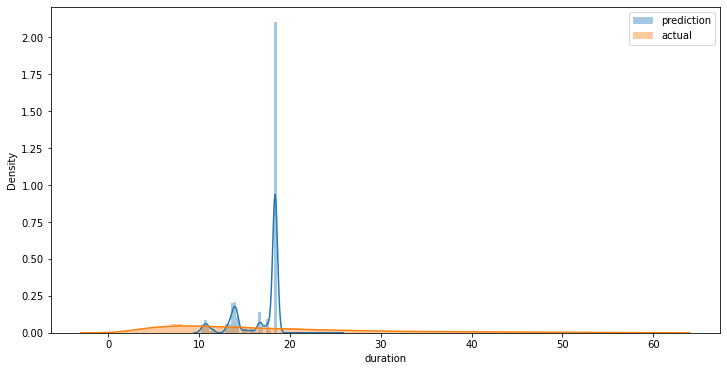

In [52]:
plt.figure(figsize=(12,6))
sns.distplot(preds_val, label='prediction')
sns.distplot(y_test, label='actual')
plt.legend();

The metrics are bad, but the main point is not in metric results but in MLOps

### MLFlow Integration

In [54]:
with mlflow.start_run():
    mlflow.set_tag('MLE', 'vlad') # tag info
    # Keep track of used data
    mlflow.log_param('train_data_path', '../data/green_tripdata_2021-01.parquet')
    mlflow.log_param('valid_data_path', '../data/green_tripdata_2021-02.parquet')
    
    alpha = 0.01
    mlflow.log_param('alpha', alpha) # log hyperparameters
    
    model = Lasso(alpha)
    model.fit(X_train, y_train)

    preds_train = model.predict(X_train)
    preds_val = model.predict(X_test)
    
    rmse_train = mean_squared_error(y_train, preds_train, squared=False)
    rmse_val = mean_squared_error(y_test, preds_val, squared=False)
    
    # Log the metrics
    mlflow.log_metric('rmse_train', rmse_train)
    mlflow.log_metric('rmse_val', rmse_val)